In [71]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [72]:
#convert images into pandas dataframes
from pathlib import Path
# path after mount: drive/MyDrive/archive (2)/chest_xray/train
#this is just us getting the data from google drive

local_dir = Path.cwd()
train_dir = local_dir / 'drive/MyDrive/archive (2)/chest_xray/train'
test_dir = local_dir / 'drive/MyDrive/archive (2)/chest_xray/test'
val_dir = local_dir / 'drive/MyDrive/archive (2)/chest_xray/val'


train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, seed=123, shuffle=True)
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, seed=123)
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir, seed=123)


Found 2682 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [73]:
#below are the preprocessing layers

# Normalizes the data
rescale = tf.keras.Sequential([
  layers.Rescaling(1./255.0)
])

#data augmentation, random flips and rotation of images
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])



In [74]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [75]:
num_classes = 2
model = tf.keras.models.Sequential()
model.add(data_augmentation) #data augmentation
model.add(rescale) #normalizing
model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)))
model.add(data_augmentation)
model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5)) #dropout added
model.add(tf.keras.layers.Dense(4096, activation='relu'))
# no dropout after the second FC layer
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [87]:
from tensorflow.python.data.ops.dataset_ops import ShuffleDataset
from tensorflow.keras.models import load_model
#load weights from model 2
model = load_model(local_dir / 'drive/MyDrive/456Project')

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history = model.fit(  train_ds,
  validation_data=val_ds,
  batch_size = 128,
  epochs=20)

Epoch 1/20
84/84 [==============================] - 6s 62ms/step - loss: 0.1246 - accuracy: 0.9605 - val_loss: 0.8245 - val_accuracy: 0.8750
Epoch 2/20
84/84 [==============================] - 5s 60ms/step - loss: 0.1044 - accuracy: 0.9620 - val_loss: 0.0404 - val_accuracy: 1.0000
Epoch 3/20
84/84 [==============================] - 5s 60ms/step - loss: 0.0701 - accuracy: 0.9754 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 4/20
84/84 [==============================] - 5s 61ms/step - loss: 0.0573 - accuracy: 0.9802 - val_loss: 0.0253 - val_accuracy: 1.0000
Epoch 5/20
84/84 [==============================] - 5s 61ms/step - loss: 0.0554 - accuracy: 0.9780 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 6/20
84/84 [==============================] - 5s 61ms/step - loss: 0.0336 - accuracy: 0.9881 - val_loss: 0.1204 - val_accuracy: 0.9375
Epoch 7/20
84/84 [==============================] - 5s 61ms/step - loss: 0.0303 - accuracy: 0.9862 - val_loss: 4.5159e-04 - val_accuracy: 1.0000
Epoch 8/2

In [88]:
score = model.evaluate(test_ds)

20/20 [==============================] - 2s 65ms/step - loss: 0.8651 - accuracy: 0.8654


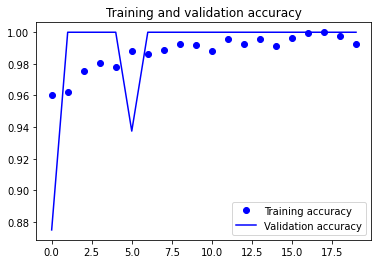

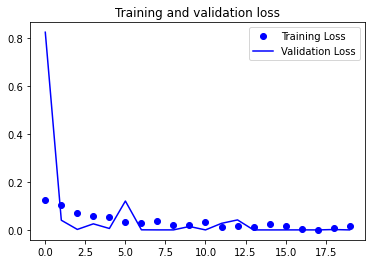

In [89]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()